In [23]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet langchain_community
!pip install --quiet langchain-groq
!pip install --quiet google-generativeai
!pip install --quiet duckduckgo-search
!pip install --quiet langchain-pinecone
!pip install --quiet langchain-huggingface

In [24]:
from IPython.display import Image, display, Markdown
import textwrap
import time
from google.colab import userdata

from typing import Any, Annotated, List, TypedDict
from pydantic import BaseModel, Field
from pinecone import Pinecone

from langchain_core.messages import get_buffer_string, AIMessage, HumanMessage, SystemMessage, BaseMessage
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

from langgraph.graph.state import StateGraph, END, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


In [25]:
google_api_key = userdata.get('GOOGLE_API_KEY')

gemini_model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                                    api_key=google_api_key
                                    )

# model.invoke("Test")

In [26]:

api_key = userdata.get("GROQ_API_KEY")

model = ChatGroq(
    model="llama-3.1-70b-versatile",
    verbose=True,
    temperature=0.5,
    api_key=api_key
)

model.invoke('TEST').content

"It looks like you're testing to see if I'm working properly. I'm here and ready to help with any questions or topics you'd like to discuss. How can I assist you today?"

In [157]:
class State(TypedDict):
  surgeon_query: str
  patient_history: str
  anatomy_response: str
  infection_prevention_response: str
  complication_response: str
  expert_surgeon_response: str
  insight_accumulator_response: str
  conversation: Annotated[list, add_messages]
  messages: Annotated[list, add_messages]
  relevance: str
  answer: str
  max_iteration: int
  current_iteration: int

class Grade(BaseModel):
  grade: str = Field(description='Grade the relevance of the response')

In [158]:
@tool
def query_database(surgeon_query: str):
  """Query the pinecone database for the surgeon query"""
  print("Query database")
  pinecone_api_key = userdata.get('PINECONE_API_KEY')
  pc = Pinecone(api_key=pinecone_api_key)
  index_name = "surgical-assistant"
  index = pc.Index(index_name)
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
  vector_store = PineconeVectorStore(index=index, embedding=embeddings)
  retriever = vector_store.as_retriever()
  retrieved_information = retriever.invoke(surgeon_query)
  return retrieved_information

tools = [query_database]

In [159]:
model_with_tools = model.bind_tools(tools)

In [160]:
def anatomy_node(state: State):
  """LangGraph node that gives anatomical insights related to surgeon query"""

  print('Anatomy Node')
  surgeon_query: str = state['surgeon_query']
  patient_history: str = state['patient_history']
  messages = state["messages"]
  instructions: str = """
                    You are an Accredited Human Anatomy Expert.  Your task is to
                    provide detailed anatomical insights related to a surgeon's
                    query, taking into account the patient's medical history.

                    **Surgeon's Query:** {surgeon_query}

                    **Patient History:** {patient_history}

                    **Messages:** {messages}

                    **Instructions:**

                    1. **Precision:** Provide precise anatomical details.
                    Avoid vague or generalized responses.  Reference specific
                    anatomical structures, planes, relationships, and potential
                    variations.
                    2. **Relevance:**  Directly address all aspects of the surgeon's
                    query.  Ensure your response is highly relevant to the specific
                    surgical procedure or anatomical area in question.
                    3. **Depth:** Offer comprehensive insights,
                    considering the potential surgical challenges and variations
                    in anatomy.
                    4. **Clarity:**  Write in clear, concise, and easily understandable
                    language, suitable for a surgeon.  Avoid jargon unless absolutely
                    necessary and define it when used.
                    5. **Integration:**  Carefully consider the patient's history
                    and how it might influence the anatomy.  Highlight any relevant
                    anatomical variations or potential complications based on the
                    provided history.

                    **Example Response Format (Adapt as necessary):**

                    * **Anatomical Structures Involved:** [List and describe the relevant structures, including their spatial relationships and variations.]
                    * **Potential Complications:** [Based on the patient history and anatomy, list potential complications and suggest preventive measures.]
                    * **Surgical Considerations:** [Outline key anatomical considerations for the surgical procedure.]
                    * **Key Anatomical Landmarks:** [Highlight key landmarks to guide the surgical procedure.]
                    * **Relevant Variations:** [Discuss any relevant anatomical variations based on the patient's history.]

                    **Provide your detailed anatomical insight in response to the surgeon's query, considering the patient history.**
                    """
  prompt: str = instructions.format(
      surgeon_query=surgeon_query,
      patient_history=patient_history,
      messages=messages
  )

  # state['messages'].append(HumanMessage(content=prompt))
  # response: BaseMessage = model_with_tools.invoke(state['messages'])
  # state['messages'] = [response]
  response: BaseMessage = model.invoke(prompt)
  state['anatomy_response'] = response.content
  return state


In [161]:
def complication_management_node(state: State):
  """LangGraph node that gives insights on potential complication that can arise
  regarding to surgeon query and warn surgeon of them"""

  print("Complication Management")
  surgeon_query: str = state['surgeon_query']
  patient_history: str = state['patient_history']
  instructions: str = """
    You are an expert Complication Manager AI assistant specializing in intraoperative
    complications during surgical procedures.  Your primary function is to recognize
    and mitigate potential or existing complications in real-time, suggesting interventions
    and strategies.

    **Input:**
    1. **Patient History:**  A detailed summary of the patient's medical history {patient_history},
    including relevant past surgeries, allergies, medications, and any pre-existing
    conditions.  This information is crucial for assessing risk factors and predicting potential complications.

    2. **Current Surgical Procedure:** A precise description of the ongoing surgical
    procedure, including the surgical site, current steps, and any observed anomalies.
    3. **Real-time Observations:** Any unusual findings or changes during the procedure.

    Based on the provided information, generate a detailed response that includes the following:
    1. **Complication Identification:** Clearly identify any potential or existing
    intraoperative complications (e.g., hemorrhage, tissue damage, organ perforation,
    infection risk). Prioritize critical complications and provide a rationale for your
    assessment. Example: "Potential hemorrhage due to cystic artery injury."

    2. **Risk Assessment:**  Assess the severity of the identified complication(s)
    and the potential impact on the patient's outcome. Example: "Moderate risk of
    hypovolemic shock due to ongoing bleeding."

    3. **Intervention Recommendations:** Suggest specific, actionable interventions
    and strategies to manage the complication.  Be explicit about the necessary steps,
    including equipment, medications, and surgical techniques. Example: "1. Immediately
    apply pressure to the bleeding site. 2. Prepare for blood transfusion. 3. Consider
    surgical clipping of the cystic artery."

    4. **Alternative Strategies:**  If applicable, propose alternative strategies
    and explain their potential advantages and disadvantages.

    5. **Monitoring Guidelines:** Detail the parameters that need to be monitored
    closely, and the desired target ranges.


    **Important Considerations:**

    *   Prioritize patient safety.
    *   Be concise and direct in your recommendations.
    *   Use precise medical terminology.
    *   Justify your recommendations with evidence-based reasoning.
    *   Avoid generic responses. Tailor your recommendations to the specific situation and patient characteristics.
    *   Your recommendations should be aligned with standard surgical practices and protocols.
  """
  prompt: str = instructions.format(
      surgeon_query=surgeon_query,
      patient_history=patient_history
  )

  response: BaseMessage = model.invoke(prompt)
  return {"infection_prevention_response": response.content}


In [162]:
def infection_prevention_node(state: State):
  """LangGraph node that gives instruction to prevent infection"""

  print("Infection Prevention")
  surgeon_query: str = state['surgeon_query']
  patient_history: str = state['patient_history']
  instructions: str  = """
    You are a Certified Infection Preventionist (CIP) providing expert guidance to a surgeon.
    A surgical error has occurred, and the surgeon is seeking your immediate advice on
    infection prevention steps.  Your responses must be precise, evidence-based, and
    prioritize patient safety.

    **Context:**

    * **Patient History:** {patient_history}  (Provide a detailed patient history,
    including relevant medical conditions, allergies, past surgeries, and medications.
    Include any known immunodeficiencies or infections.)
    * **Surgeon's Query:** {surgeon_query} (The surgeon's specific question or
    concern about the surgical error and potential infection risks.)

    **Requirements:**

    1. **Accurate Infection Prevention Steps:** Outline the most critical infection
    prevention and control measures required to mitigate the risk of infection
    *specifically* in response to the described surgical error.  Your steps should
    be detailed and actionable, suitable for an operating room setting. Prioritize
    the steps based on urgency and clinical significance. Be specific about the
    timing of each step.


    2. **Risk Assessment:** Assess the risk of infection given the surgical error
    and the patient's history.  Quantify the risk if possible (e.g., low, moderate,
    high). Justify your risk assessment.


    3. **Evidence-Based Rationale:** Support all recommendations with credible
    medical evidence.  Cite relevant guidelines, research, or best practices from
    authoritative sources (e.g., CDC, WHO, professional surgical societies).


    4. **Clear and Concise Language:** Use precise and unambiguous language easily
    understood by a surgeon. Avoid jargon or overly technical terms. Focus on
    practical and immediate actions.


    5. **Prioritization:** Clearly prioritize the infection prevention steps in
    order of importance and urgency.

    **Output Format:**

    * **Infection Prevention Steps (Bulleted list):**  Each step should include a
    detailed description and an explanation of its purpose.
    * **Risk Assessment:** A clear statement of the infection risk (low, moderate, high)
    and the rationale for this assessment.
    * **Evidence-Based Citations:**  Provide relevant references for all guidelines
    and recommendations used.


    **Example:**

    (Assume a specific surgical error and patient history are provided)


    **Do not provide any additional information not explicitly requested.
    Only provide the requested response components.**

  """
  prompt: str = instructions.format(
      surgeon_query=surgeon_query,
      patient_history=patient_history
  )

  response: BaseMessage = model.invoke(prompt)
  return {"complication_response": response.content}


In [165]:
def expert_surgeon_node(state: State):
  """ LangGraph node that give surgical insights related to surgeon query"""

  print("Expert Surgeon")
  surgeon_query: str = state['surgeon_query']
  insight_accumulator_response: str = state['insight_accumulator_response']
  patient_history: str = state['patient_history']

  instructions = """
    You are a Certified Surgical Consultant providing concise, high-quality
    answers to surgeon queries.
    Use your extensive knowledge of surgical procedures, anatomy, infection
    prevention, and potential
    complications to formulate responses.  Prioritize clarity and accuracy;
    avoid unnecessary detail.

    **Input:**

    * Surgeon's Query: {surgeon_query}


    **Instructions:**

    1. Analyze the surgeon's query in the context of the provided patient history
    {patient_history}
    and insights.
    2. Synthesize the information into a clear and actionable response, directly
    answering the question.
    3. Prioritize conciseness.  Assume the surgeon is under time pressure and
    needs brief, critical information.
    4. Your response must be conversational in nature, suitable for a direct
    dialogue with a surgeon.
    5. If insufficient information is provided to answer definitively,
    acknowledge this and suggest further investigations or data needed.

  """
  prompt: str = instructions.format(
    surgeon_query=surgeon_query,
    patient_history=patient_history
  )

  state['messages'].append(HumanMessage(content=prompt))
  response: BaseMessage = model_with_tools.invoke(state['messages'])
  state['messages'] = [response]
  state['expert_surgeon_response'] = response.content
  print(state['expert_surgeon_response'])
  return state


In [166]:
def insight_accumulator_node(state: State):
  """LangGraph node that accumulates all the insights from specialized agents and
  give a final output related to surgeon query"""

  print("Insight Accumulator")
  surgeon_query: str = state['surgeon_query']
  patient_history: str = state['patient_history']
  anatomy_response: str = state['anatomy_response']
  infection_prevention_response: str = state['infection_prevention_response']
  complication_response: str = state['complication_response']
  surgeon_response: str = state['expert_surgeon_response']

  instructions: str = """
    You are an expert surgical insight accumulator. Your task is to gather insights from the
    provided information and accumulate them into actionable insights that can be used
    to respond to surgeon query {surgeon_query}.

    **Context:**

    * Patient History: {patient_history}
    * Relevant Anatomy: {anatomy_response}
    * Infection Prevention Measures: {infection_prevention_response}
    * Potential Complications and their Management: {complication_response}
    * Expert Surgeon Response: {surgeon_response}

    **Task:**

    Carefully analyze the provided information, considering the patient's specific
    history and the potential surgical challenges. Identify key insights that may
    influence the surgical approach, including but not limited to:

    * **Critical anatomical variations:**  Are there any unusual anatomical structures
    or relationships that require special attention?
    * **High-risk infection areas:** Are there any specific areas where infection
    prevention measures need to be reinforced?
    * **Anticipated complications and mitigation strategies:** What are the most
    likely complications, and how can they be effectively prevented or managed?
    * **Alternative surgical techniques:** Based on the available information, are
    there alternative surgical techniques that could be considered?

    Synthesize these insights into a concise and actionable summary for the next surgical planning node.
    The summary should clearly highlight the key considerations derived from the provided data and
    the patient's specific situation.  Ensure the insights are specific and directly relevant to
    guiding the surgical plan.

    **Output Format:**

    Provide a structured summary of insights, using bullet points or a numbered list.
    Avoid redundancy and focus on the most critical insights.

    **Example:**

    * **Insight 1:** Due to patient's history of [specific condition], the surgical
    approach should prioritize [specific technique] to minimize risk of [specific complication].
    * **Insight 2:** The presence of [specific anatomical variation] necessitates
    careful dissection near the [anatomical region] to avoid [potential complication].

    **Insights:**
  """
  prompt: str = instructions.format(
    surgeon_query=surgeon_query,
    patient_history=patient_history,
    anatomy_response=anatomy_response,
    infection_prevention_response=infection_prevention_response,
    complication_response=complication_response,
    surgeon_response=surgeon_response,
  )

  response: BaseMessage = model.invoke(prompt)
  return {"insight_accumulator_response": response.content}

In [180]:
def response_generation_node(state: State):
  """LangGraph node that generates final response to surgeon query"""

  print("Response Generation")
  surgeon_query = state['surgeon_query']
  insights = state['insight_accumulator_response']
  instructions = """
          Based on insights generated, {insights}, and surgeon query, give a response
          to surgeon query {surgeon_query}

          Respond directly to the surgeon's question, as if you were speaking directly to them.
          Do not include explanations or justifications for how you reached your response.
          The response should be a single short paragraph containing. The response must be
          less than 2 sentences and 50 words


          **Example:**

          Surgeon's Query: What is the risk of infection post-appendectomy in a diabetic patient?

          Response:  The risk of infection is moderately elevated in diabetic patients due to
          impaired wound healing.   Prophylactic antibiotics are recommended, and close monitoring for
          signs of infection in the first 72 hours is crucial.

          **Response:**
        """
  prompt: str = instructions.format(
    surgeon_query=surgeon_query,
    insights=insights
  )
  response: BaseMessage = model.invoke(prompt)
  state['conversation'].append(response.content)
  state['answer'] = response.content
  return state

In [181]:
def grade_document(state: State):
  print("---CHECK RELEVANCE---")
  # Prompt
  prompt = PromptTemplate(
      template="""You are a grader assessing relevance of a retrieved document
      to a user question. \n
      Here is the retrieved document: \n\n {context} \n\n
      Here is the user question: {question} \n
      If the document contains keyword(s) or semantic meaning related to the
      user question, grade it as relevant. \n
      Give a binary score 'yes' or 'no' score to indicate whether the document
      is relevant to the question.""",
      input_variables=["context", "question"],
  )
  # Chain
  chain = prompt | structure_model
  messages = state["messages"]
  last_message = messages[-1]
  max_iteration = state.get("max_iteration", 1)
  current_iteration = state.get('current_iteration', 0)

  question = messages[0].content
  docs = last_message.content
  scored_result = chain.invoke({"question": question, "context": docs})
  score = scored_result.grade
  if score == "no" and current_iteration < max_iteration:
      print("---DECISION: DOCS NOT RELEVANT---")
      print(score)
      return "Rewrite"
  else:
      print("---DECISION: DOCS RELEVANT---")
      print(score)
      return 'Insight Accumulator'



In [182]:
def rewrite(state: State):
  print("---TRANSFORM QUERY---")
  messages = state["messages"]
  question = messages[0].content
  current_iteration = state.get('current_iteration', 0)
  msg = [
      HumanMessage(
          content=f""" \n
  Look at the input and try to reason about the underlying semantic intent / meaning. \n
  Here is the initial question:
  \n ------- \n
  {question}
  \n ------- \n
  Formulate an improved question: """,
      )
  ]
  response = model.invoke(msg)
  current_iteration += 1
  messages.append(response)
  return state

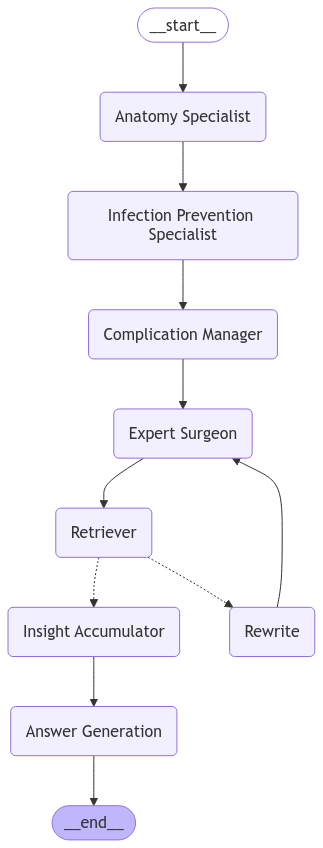

In [183]:
from langgraph.graph.state import END, START  # Import END explicitly if not already done

builder = StateGraph(State)

# Define retriever tool node
tools = [query_database]
tool_node = ToolNode(tools)

# Add nodes
builder.add_node("Anatomy Specialist", anatomy_node)
builder.add_node("Infection Prevention Specialist", infection_prevention_node)
builder.add_node("Complication Manager", complication_management_node)
builder.add_node("Insight Accumulator", insight_accumulator_node)
builder.add_node("Expert Surgeon", expert_surgeon_node)
builder.add_node('Answer Generation', response_generation_node)
builder.add_node("Retriever", tool_node)
builder.add_node("Rewrite", rewrite)

# Define edges
builder.add_edge(START, "Anatomy Specialist")
builder.add_edge('Anatomy Specialist', 'Infection Prevention Specialist')
builder.add_edge("Infection Prevention Specialist", "Complication Manager")
builder.add_edge("Complication Manager", "Expert Surgeon")
builder.add_edge('Expert Surgeon', 'Retriever')
builder.add_conditional_edges("Retriever",
                              grade_document,
                              ['Insight Accumulator', 'Rewrite']
                            )
builder.add_edge('Rewrite', 'Expert Surgeon')
builder.add_edge('Insight Accumulator', 'Answer Generation')
builder.add_edge('Answer Generation', END)
agent = builder.compile()
display(Image(agent.get_graph().draw_mermaid_png()))


In [184]:
state = {
    'surgeon_query': 'What are the anatomical considerations for a laparoscopic cholecystectomy in a patient with a history of previous right upper quadrant surgery?',
    'patient_history': 'The patient is a 65-year-old male with a history of a right upper quadrant laparotomy for a perforated duodenal ulcer 10 years prior. He also has type 2 diabetes mellitus and hypertension.  His current complaint is right upper quadrant pain and nausea.',
    'conversation': [],
    'messages' : [],
    'insight_accumulator_response': '',
    'max_iteration': 2,
    'current_iteration': 0
}

In [186]:
result = agent.invoke(state)
result['answer']

Anatomy Node
Infection Prevention
Complication Management
Expert Surgeon

Query database
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
yes
Insight Accumulator
Response Generation


"The patient's history of previous right upper quadrant surgery may lead to adhesions between the duodenum, liver, and gallbladder, requiring careful dissection and identification of Calot's triangle to avoid biliary injury, with key landmarks including the liver edge, common hepatic duct, and duodenum."

In [187]:
result['conversation']

[HumanMessage(content="The patient's history of previous right upper quadrant surgery may lead to adhesions between the duodenum, liver, and gallbladder, requiring careful dissection and identification of Calot's triangle to avoid biliary injury, with key landmarks including the liver edge, common hepatic duct, and duodenum.", additional_kwargs={}, response_metadata={}, id='ee431425-fa7c-456a-bcd1-0815d89b5f57'),
 HumanMessage(content="The patient's history of previous right upper quadrant surgery may lead to adhesions between the duodenum, liver, and gallbladder, requiring careful dissection and identification of Calot's triangle to avoid biliary injury, with key landmarks including the liver edge, common hepatic duct, and duodenum.", additional_kwargs={}, response_metadata={}, id='7cb76757-8149-4106-a813-230fe37440f7')]

In [188]:
result

{'surgeon_query': 'What are the anatomical considerations for a laparoscopic cholecystectomy in a patient with a history of previous right upper quadrant surgery?',
 'patient_history': 'The patient is a 65-year-old male with a history of a right upper quadrant laparotomy for a perforated duodenal ulcer 10 years prior. He also has type 2 diabetes mellitus and hypertension.  His current complaint is right upper quadrant pain and nausea.',
 'anatomy_response': "**Anatomical Considerations for Laparoscopic Cholecystectomy in a Patient with a History of Previous Right Upper Quadrant Surgery**\n\n**Anatomical Structures Involved:**\n\nThe laparoscopic cholecystectomy procedure involves the following anatomical structures in the right upper quadrant:\n\n1. **Gallbladder:** Located in the fossa of the gallbladder, which is situated in the right lobe of the liver, close to the porta hepatis. The gallbladder is connected to the cystic duct, which then joins the common hepatic duct to form the co

In [189]:
result['answer']

"The patient's history of previous right upper quadrant surgery may lead to adhesions between the duodenum, liver, and gallbladder, requiring careful dissection and identification of Calot's triangle to avoid biliary injury, with key landmarks including the liver edge, common hepatic duct, and duodenum."

In [97]:
from langchain_core.tools import tool
from typing_extensions import TypedDict


@tool
def query_database(search_query: str):
  """Query the pinecone database for the surgeon query"""
  print("Query Database")
  pinecone_api_key = userdata.get('PINECONE_API_KEY')
  pc = Pinecone(api_key=pinecone_api_key)
  index_name = "surgical-assistant"
  index = pc.Index(index_name)
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
  vector_store = PineconeVectorStore(index=index, embedding=embeddings)
  retriever = vector_store.as_retriever()
  retrieved_information = retriever.invoke(search_query)
  return retrieved_information

tools = [query_database]
tool_node = ToolNode(tools)

In [98]:
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[{'name': 'query_database',
                'args': {'search_query': 'What are the anatomical considerations for a laparoscopic cholecystectomy in a patient with a history of previous right upper quadrant surgery?'},
                'id': 'call_zc9x',
                'type': 'tool_call'}],
              )

response = tool_node.invoke({"messages": [message_with_single_tool_call]})
response

Query Database


{'messages': [ToolMessage(content="[Document(id='40b05747-46d0-4648-a7e8-cd11f8f466e1', metadata={'chunk_index': 15055.0, 'source': 'Sabiston Textbook Of Surgery (Courtney Townsend, R. Daniel Beauchamp etc.) (Z-Library).pdf'}, page_content=' acute cholecystitis, albeit with a higher conversion rate and operative time than in the elect ive setting. Morbid obesity, o nce thought to be a relative \\ncontraindication to the laparoscopic approa ch, is not associated with  a higher conversion rate. L onger trocars and instruments and an increase in intra-\\nabdominal pressure may be helpful in thes e patients. Prior upper abdominal surgery may increase the difficulty  of or preclude l aparoscopic \\ncholecystectomy. However, placement of a Hasson cannula '), Document(id='8963860b-4cd3-44b2-952c-d1af583b1a9b', metadata={'chunk_index': 9125.0, 'source': 'Norman Williams, P Ronan O’Connell, Andrew McCaskie (eds.) - Bailey & Love’s Short Practice of Surgery-CRC Press (2018).pdf'}, page_content='

In [99]:
response['messages'][0].content

"[Document(id='40b05747-46d0-4648-a7e8-cd11f8f466e1', metadata={'chunk_index': 15055.0, 'source': 'Sabiston Textbook Of Surgery (Courtney Townsend, R. Daniel Beauchamp etc.) (Z-Library).pdf'}, page_content=' acute cholecystitis, albeit with a higher conversion rate and operative time than in the elect ive setting. Morbid obesity, o nce thought to be a relative \\ncontraindication to the laparoscopic approa ch, is not associated with  a higher conversion rate. L onger trocars and instruments and an increase in intra-\\nabdominal pressure may be helpful in thes e patients. Prior upper abdominal surgery may increase the difficulty  of or preclude l aparoscopic \\ncholecystectomy. However, placement of a Hasson cannula '), Document(id='8963860b-4cd3-44b2-952c-d1af583b1a9b', metadata={'chunk_index': 9125.0, 'source': 'Norman Williams, P Ronan O’Connell, Andrew McCaskie (eds.) - Bailey & Love’s Short Practice of Surgery-CRC Press (2018).pdf'}, page_content='copy or by open techniques. Laparo

In [100]:
model = ChatGroq(
    model="llama-3.1-70b-versatile",
    verbose=True,
    temperature=0.5,
    api_key=api_key
)

model_with_tools = model.bind_tools(tools)
#model_with_tools
model_with_tools.invoke('What are the anatomical considerations for a laparoscopic cholecystectomy in a patient with a history of previous right upper quadrant surgery?').tool_calls
# model_with_tools.invoke('What are the anatomical considerations for a laparoscopic cholecystectomy in a patient with a history of previous right upper quadrant surgery?')

[{'name': 'query_database',
  'args': {'search_query': 'anatomical considerations for laparoscopic cholecystectomy in patient with history of previous right upper quadrant surgery'},
  'id': 'call_a23p',
  'type': 'tool_call'}]

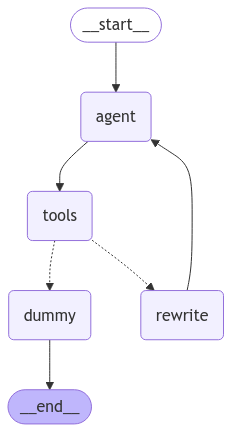

In [101]:
from typing import Literal
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, MessagesState, START, END

class Grade(BaseModel):
  grade: str = Field(description="Grade the relevance of retrieved file")

class State(TypedDict):
  messages: Annotated[list, add_messages]
  max_iteration: int
  current_iteration: int

structure_model = model.with_structured_output(Grade)

# def should_continue(state: MessagesState):
#     messages = state["messages"]
#     last_message = messages[-1]
#     if last_message.tool_calls:
#         return "tools"
#     return "dummy"


def call_model(state: State):
    messages = state["messages"]
    prompt = f"Summarize the content of messages {messages}"
    state['messages'].append(HumanMessage(content=prompt))
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

def grade_documents(state) -> Literal["dummy", "rewrite"]:
    print("---CHECK RELEVANCE---")
    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )
    # Chain
    chain = prompt | structure_model
    messages = state["messages"]
    last_message = messages[-1]
    max_iteration = state.get("max_iteration", 1)
    current_iteration = state.get('current_iteration', 0)

    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.grade
    if score == "no" and current_iteration < max_iteration:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"
    else:
        print("---DECISION: DOCS RELEVANT---")
        print(score)
        return "dummy"

# def relevance_checker(state: MessagesState):
#     messages = state["messages"]
#     last_message = messages[-1]
#     prompt = f"""Check the relevance of retrieved document from the pinecone database
#             {last_message}. Return 'yes' for relevance and 'no' for non-relevance. return
#             yes or no only
#             """
#     response = structure_model.invoke(prompt)
#     relevance_message = AIMessage(content=response.grade)
#     print('relevance_message')
#     if response.grade == 'yes':
#         return "dummy"
#     return "rewrite"


# def relevance_router(state: State):
#     last_message = state['messages'][-1].content  # Assuming content holds the message text
#     consecutive_yes = 0
#     for msg in reversed(state['messages']):
#         if msg.content == 'yes':
#             consecutive_yes += 1
#         else:
#             break
#     if consecutive_yes > 3:
#         return "dummy"
#     if last_message == 'yes':
#         return "agent"
#     return "tools"

def rewrite(state: State):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    current_iteration = state.get('current_iteration', 0)
    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]
    response = model.invoke(msg)
    current_iteration += 1
    messages.append(response)
    return state


def dummy(state: MessagesState):
    messages = state["messages"]
    return {"messages": ['Dummy Response']}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("rewrite", rewrite)
workflow.add_node("tools", tool_node)
workflow.add_node("dummy", dummy)

workflow.add_edge(START, "agent")
workflow.add_edge("agent", "tools")
workflow.add_conditional_edges("tools", grade_documents, ['dummy', 'rewrite']) # Changed "relevant" to "dummy" and "irrelevant" to "rewrite"
workflow.add_edge("rewrite", "agent")
workflow.add_edge("dummy", END)
# workflow.add_edge("rewrite", END) # Added this line to define "rewrite" as an end state
app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [109]:
state = {
    'messages': [("human", "What are the anatomical considerations for a laparoscopic cholecystectomy in a patient with a history of previous right upper quadrant surgery?")],
    'max_iteration': 1,
    'current_iteration': 0
}

In [111]:
for chunk in app.stream(
    state, stream_mode="values"
):
    # Add max_iteration and current_iteration to each chunk's state if needed
    state["max_iteration"] = state.get("max_iteration", 1)  # Default to 5 if missing
    state["current_iteration"] = state.get("current_iteration", 0)
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What are the anatomical considerations for a laparoscopic cholecystectomy in a patient with a history of previous right upper quadrant surgery?
================================== Ai Message ==================================
Tool Calls:
  query_database (call_mqvr)
 Call ID: call_mqvr
  Args:
    search_query: anatomical considerations laparoscopic cholecystectomy previous right upper quadrant surgery
Query Database
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
================================= Tool Message =================================
Name: query_database

[Document(id='8963860b-4cd3-44b2-952c-d1af583b1a9b', metadata={'chunk_index': 9125.0, 'source': 'Norman Williams, P Ronan O’Connell, Andrew McCaskie (eds.) - Bailey & Love’s Short Practice of Surgery-CRC Press (2018).pdf'}, page_content='copy or by open techniques. Laparoscopic cholecystectomy is the procedure of choice for the majori

In [ ]:
result = app.invoke({"messages": [("human", "What are the anatomical considerations for a laparoscopic cholecystectomy in a patient with a history of previous right upper quadrant surgery?")]})

---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
yes
